In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
import plotly.graph_objects as go
import plotly.graph_objects as go
from sktime.forecasting.model_selection import temporal_train_test_split
from tabulate import tabulate

%matplotlib inline

import warnings
import datetime

warnings.filterwarnings("ignore")

In [2]:
huwaei=pd.read_csv('training_100.csv')
cols=[i for i in huwaei.columns if i not in ['timestamp']]
for col in cols:
    huwaei[col]=pd.to_numeric(huwaei[col])
huwaei['timestamp'] = pd.to_datetime(huwaei['timestamp'])

huwaei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20159 entries, 0 to 20158
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype                                
---  ------         --------------  -----                                
 0   timestamp      20159 non-null  datetime64[ns, pytz.FixedOffset(120)]
 1   kpi_value      20159 non-null  float64                              
 2   request_count  20159 non-null  int64                                
 3   anomaly_label  20159 non-null  int64                                
dtypes: datetime64[ns, pytz.FixedOffset(120)](1), float64(1), int64(2)
memory usage: 630.1 KB


In [3]:
huwaei['hour'] = huwaei['timestamp'].dt.hour
huwaei['minute'] = huwaei['timestamp'].dt.minute
huwaei

,timestamp,kpi_value,request_count,anomaly_label,hour,minute
0,2020-08-14 02:00:00+02:00,0.998755,24908,0,2,0
1,2020-08-14 02:01:00+02:00,0.997683,25029,0,2,1
2,2020-08-14 02:02:00+02:00,0.998341,24115,0,2,2
3,2020-08-14 02:03:00+02:00,0.998211,24031,0,2,3
4,2020-08-14 02:04:00+02:00,0.998403,23790,0,2,4
...,...,...,...,...,...,...
20154,2020-08-28 01:56:00+02:00,0.998149,26467,0,1,56
20155,2020-08-28 01:57:00+02:00,0.998340,26502,0,1,57
20156,2020-08-28 01:58:00+02:00,0.998364,26887,0,1,58
20157,2020-08-28 01:59:00+02:00,0.998428,26712,0,1,59


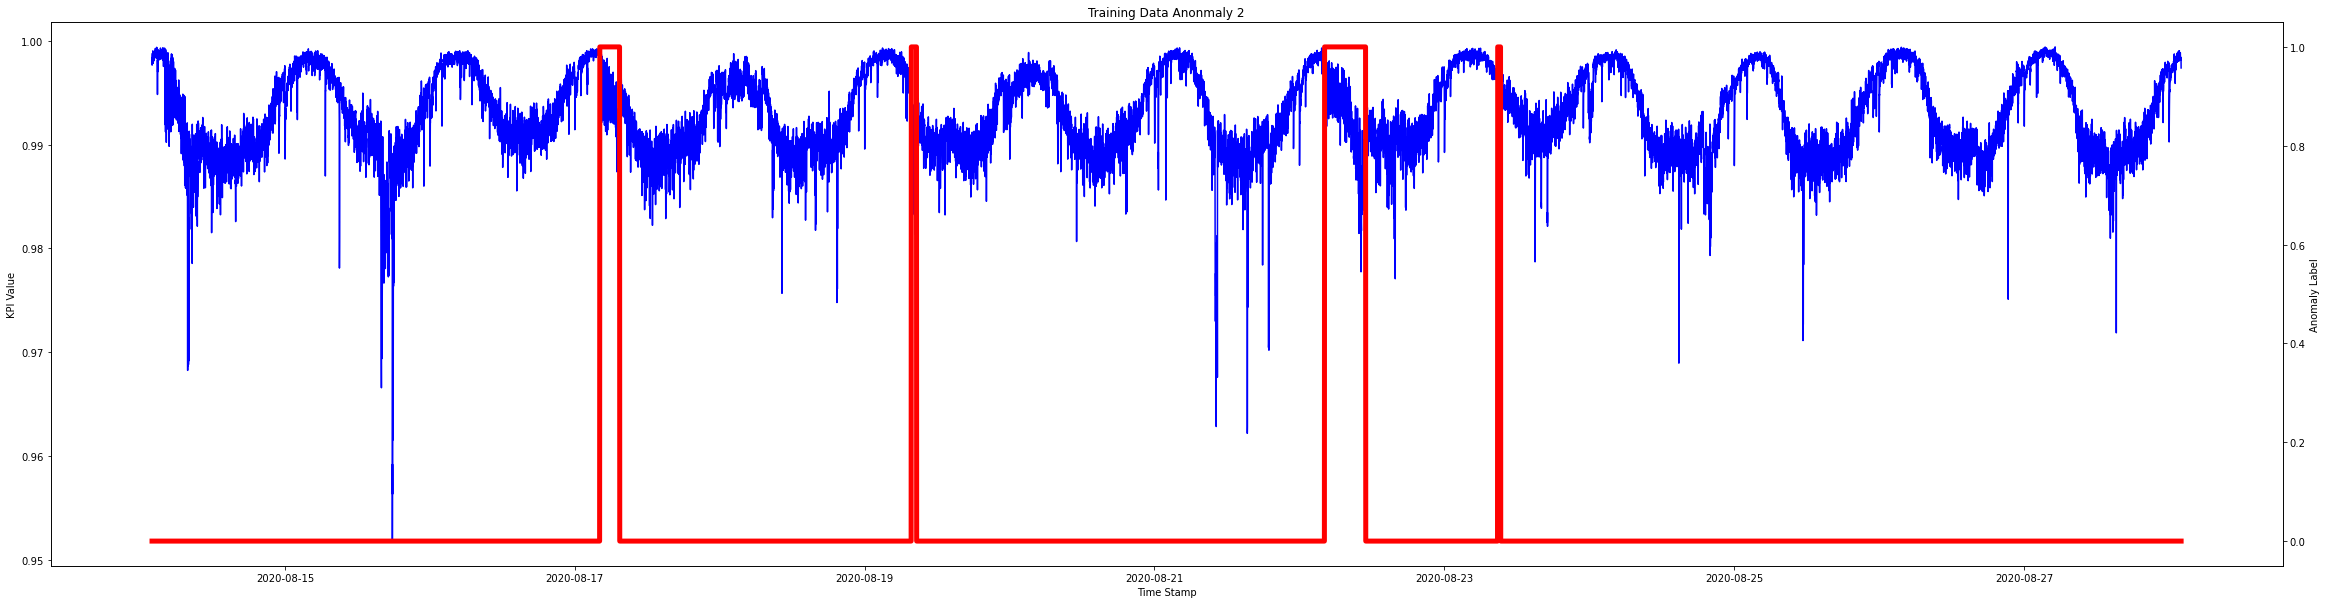

In [4]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('KPI Value')
ax2a.set_ylabel('Anomaly Label')
ax2d.title.set_text('Training Data Anonmaly 2')

In [5]:
huwaei_dataset=huwaei[['timestamp', 'kpi_value', 'hour', 'minute']]
#dataset

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(huwaei_dataset['timestamp'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

# datetime_index
period_index = pd.PeriodIndex(datetime_index, freq='S')

# period_index
huwaei_dataset = huwaei_dataset.set_index(period_index)

# we don't need the column anymore
huwaei_dataset.drop('timestamp',axis=1,inplace=True)

huwaei_dataset.head()
# print(len(dataset))

,kpi_value,hour,minute
2020-08-14 00:00:00,0.998755,2,0
2020-08-14 00:01:00,0.997683,2,1
2020-08-14 00:02:00,0.998341,2,2
2020-08-14 00:03:00,0.998211,2,3
2020-08-14 00:04:00,0.998403,2,4


In [6]:
contamination=8.565000000000001
contamination=contamination/100

from sklearn.neighbors import LocalOutlierFactor

# copying dataset
isf_dataset = huwaei_dataset.copy()

# initializing Isolation Forest
clf = LocalOutlierFactor(n_neighbors=10, contamination=contamination)

# training
clf.fit(isf_dataset.values)

# finding anomalies
isf_dataset['Anomaly'] = clf.fit_predict(isf_dataset.values) 

# saving anomalies to a separate dataset for visualization purposes
# anomalies_single = isf_dataset.query('Anomaly == -1')
anomalies=isf_dataset

In [7]:
total_contamination=len(anomalies)

In [8]:
output=anomalies

In [9]:
anomalies

,kpi_value,hour,minute,Anomaly
2020-08-14 00:00:00,0.998755,2,0,1
2020-08-14 00:01:00,0.997683,2,1,1
2020-08-14 00:02:00,0.998341,2,2,1
2020-08-14 00:03:00,0.998211,2,3,1
2020-08-14 00:04:00,0.998403,2,4,1
...,...,...,...,...
2020-08-27 23:56:00,0.998149,1,56,1
2020-08-27 23:57:00,0.998340,1,57,1
2020-08-27 23:58:00,0.998364,1,58,1
2020-08-27 23:59:00,0.998428,1,59,1


In [10]:
anomalies["Anomaly"]=anomalies["Anomaly"].replace(1, 0) #No Anomalies
anomalies["Anomaly"]=anomalies["Anomaly"].replace(-1, 1) #Anomalies
anomalies

,kpi_value,hour,minute,Anomaly
2020-08-14 00:00:00,0.998755,2,0,0
2020-08-14 00:01:00,0.997683,2,1,0
2020-08-14 00:02:00,0.998341,2,2,0
2020-08-14 00:03:00,0.998211,2,3,0
2020-08-14 00:04:00,0.998403,2,4,0
...,...,...,...,...
2020-08-27 23:56:00,0.998149,1,56,0
2020-08-27 23:57:00,0.998340,1,57,0
2020-08-27 23:58:00,0.998364,1,58,0
2020-08-27 23:59:00,0.998428,1,59,0


In [11]:
moving_average=anomalies['Anomaly'].rolling(50).mean()
moving_average

2020-08-14 00:00:00    NaN
2020-08-14 00:01:00    NaN
2020-08-14 00:02:00    NaN
2020-08-14 00:03:00    NaN
2020-08-14 00:04:00    NaN
                      ... 
2020-08-27 23:56:00    0.0
2020-08-27 23:57:00    0.0
2020-08-27 23:58:00    0.0
2020-08-27 23:59:00    0.0
2020-08-28 00:00:00    0.0
Freq: S, Name: Anomaly, Length: 20159, dtype: float64

In [12]:
moving_average.min()

0.0

In [13]:
moving_average.std()

0.1571194495027931

In [14]:
threshold_6sigma=6*moving_average.std()
threshold_60percentmax=0.6*moving_average.max()

In [15]:
threshold_6sigma

0.9427166970167586

In [16]:
threshold_60percentmax

0.588

In [17]:
moving_average.max()

0.98

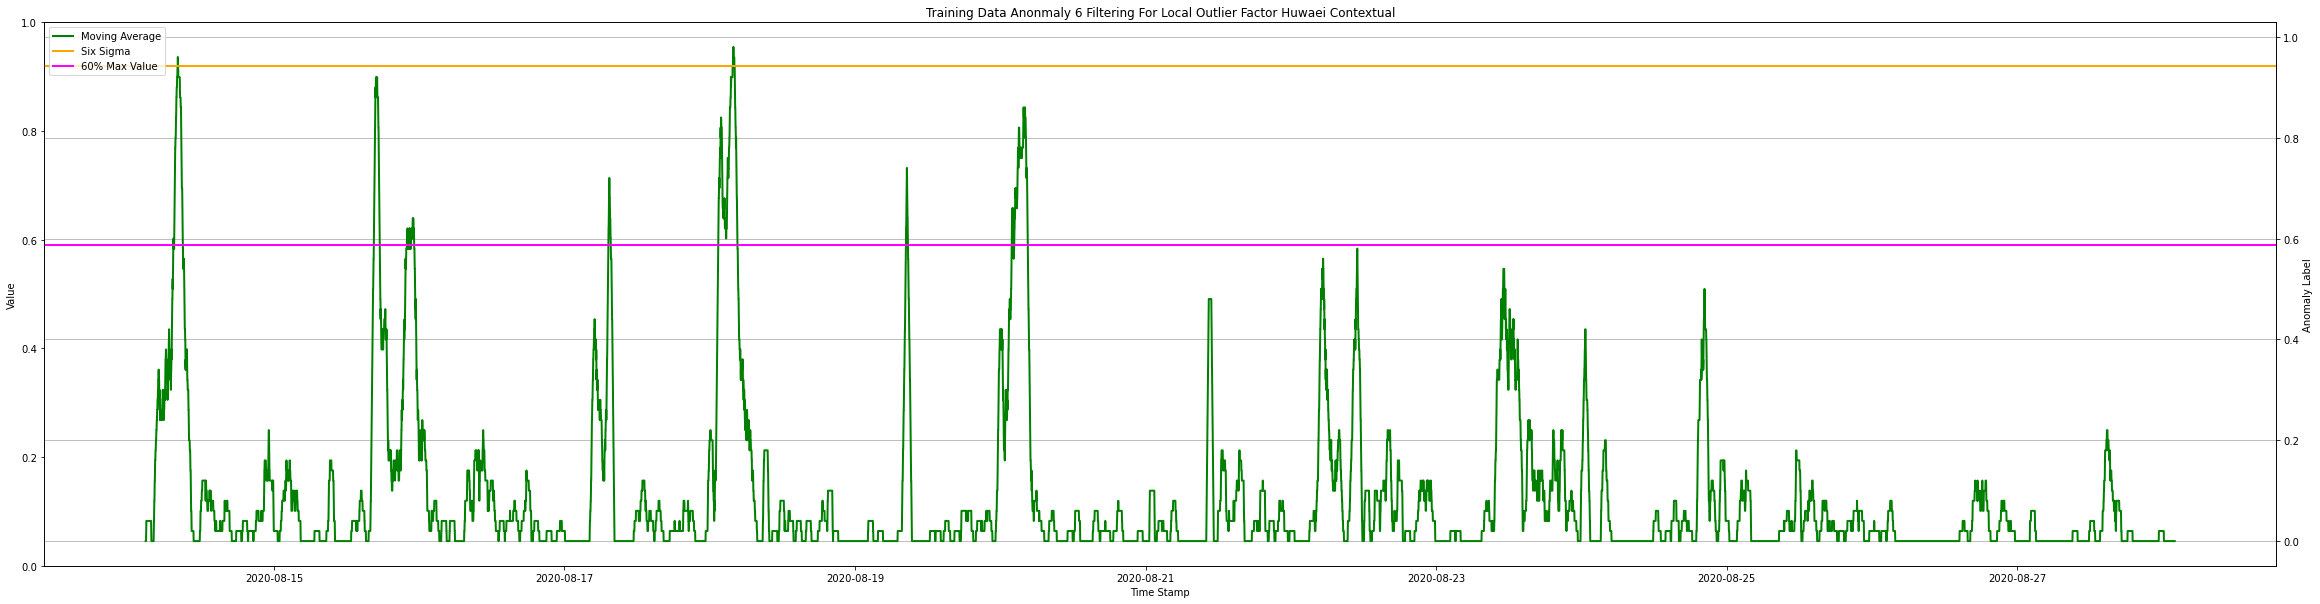

In [18]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
#ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
#ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2a.plot(huwaei['timestamp'], moving_average, color='green', linewidth='2')
ax2a.axhline(threshold_6sigma, color='orange', linewidth='2') # Line for the six sigma
ax2a.axhline(threshold_60percentmax, color='magenta', linewidth='2') # Line for the 60% the highest value
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('Value')
ax2a.set_ylabel('Anomaly Label')
ax2a.legend(['Moving Average', 'Six Sigma', '60% Max Value'], loc='upper left')
plt.grid()
ax2d.title.set_text('Training Data Anonmaly 6 Filtering For Local Outlier Factor Huwaei Contextual')
plt.savefig('Training Data Anonmaly 6 Filtering For Local Outlier Factor Huwaei Contextual') 

In [19]:
moving_average=moving_average.dropna(how="all")
moving_average

2020-08-14 00:49:00    0.0
2020-08-14 00:50:00    0.0
2020-08-14 00:51:00    0.0
2020-08-14 00:52:00    0.0
2020-08-14 00:53:00    0.0
                      ... 
2020-08-27 23:56:00    0.0
2020-08-27 23:57:00    0.0
2020-08-27 23:58:00    0.0
2020-08-27 23:59:00    0.0
2020-08-28 00:00:00    0.0
Freq: S, Name: Anomaly, Length: 20110, dtype: float64

In [20]:
len(moving_average)

20110

In [21]:
threshold_60percentmax

0.588

In [22]:
n=0
a=0

new_anomalies_60percentmax=[]

for i in range(len(moving_average)):
    if moving_average[i] <= threshold_60percentmax:
        n=n+1
        t=0
        new_anomalies_60percentmax.append(t)
    elif moving_average[i] > threshold_60percentmax:
        a=a+1
        t=1
        new_anomalies_60percentmax.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 19518
Number of anomalies: 592


In [23]:
n=0
a=0

new_anomalies_threshold_6sigma=[]

for i in range(len(moving_average)):
    if moving_average[i] <= threshold_6sigma:
        n=n+1
        t=0
        new_anomalies_threshold_6sigma.append(t)
    elif moving_average[i] > threshold_6sigma:
        a=a+1
        t=1
        new_anomalies_threshold_6sigma.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 20095
Number of anomalies: 15


In [24]:
print(len(huwaei['timestamp']))
print(len(new_anomalies_60percentmax))
print(len(new_anomalies_threshold_6sigma))

20159
20110
20110


In [25]:
labeled_anomalies=huwaei['anomaly_label'][20159-20110:20158]

In [26]:
labeled_anomalies=labeled_anomalies.reset_index(drop=True)
labeled_anomalies

0        0
1        0
2        0
3        0
4        0
        ..
20104    0
20105    0
20106    0
20107    0
20108    0
Name: anomaly_label, Length: 20109, dtype: int64

In [27]:
new_anomalies_60percentmax # New Anomalies from moving average
new_anomalies_threshold_6sigma
labeled_anomalies # Labeled Anomalies

0        0
1        0
2        0
3        0
4        0
        ..
20104    0
20105    0
20106    0
20107    0
20108    0
Name: anomaly_label, Length: 20109, dtype: int64

In [28]:
tp60m=0
fp60m=0
tn60m=0
fn60m=0
for i in range(len(labeled_anomalies)):
    if new_anomalies_60percentmax[i] == 1 and labeled_anomalies[i] == 1:
            tp60m=tp60m+1
    elif new_anomalies_60percentmax[i] == 1 and labeled_anomalies[i] != 1:
            fp60m=fp60m+1
    elif new_anomalies_60percentmax[i] != 1 and labeled_anomalies[i] == 1:
            fn60m=fn60m+1
    elif new_anomalies_60percentmax[i] != 1 and labeled_anomalies[i] != 1:
            tn60m=tn60m+1

In [29]:
tp6s=0
fp6s=0
tn6s=0
fn6s=0
for i in range(len(labeled_anomalies)):
    if new_anomalies_threshold_6sigma[i] == 1 and labeled_anomalies[i] == 1:
            tp6s=tp6s+1
    elif new_anomalies_threshold_6sigma[i] == 1 and labeled_anomalies[i] != 1:
            fp6s=fp6s+1
    elif new_anomalies_threshold_6sigma[i] != 1 and labeled_anomalies[i] == 1:
            fn6s=fn6s+1
    elif new_anomalies_threshold_6sigma[i] != 1 and labeled_anomalies[i] != 1:
            tn6s=tn6s+1

In [30]:
print("THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp60m}")
print(f"Number of False Positives: {fp60m}")
print(f"Number of True Negatives: {tn60m}")
print(f"Number of False Negatives: {fn60m}")
print("###################################")

precision_60m=tp60m/(tp60m+fp60m)
recall_60m=tp60m/(tp60m+fn60m)
F1_Score_60m=(2*precision_60m*recall_60m)/(precision_60m+recall_60m)

print(f"Precision: {round(precision_60m,3)}")
print(f"Recall: {round(recall_60m,3)}")
print(f"F1 Score: {round(F1_Score_60m,3)}")

THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 21
Number of False Positives: 571
Number of True Negatives: 18848
Number of False Negatives: 669
###################################
Precision: 0.035
Recall: 0.03
F1 Score: 0.033


In [31]:
print("THIS IS FROM USING THE THRESHOLD AS 6 SIGMA VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp6s}")
print(f"Number of False Positives: {fp6s}")
print(f"Number of True Negatives: {tn6s}")
print(f"Number of False Negatives: {fn6s}")
print("###################################")

precision_6s=tp6s/(tp6s+fp6s)
recall_6s=tp6s/(tp6s+fn6s)
F1_Score_6s=(2*precision_6s*recall_6s)/(precision_6s+recall_6s)

print(f"Precision: {round(precision_6s,3)}")
print(f"Recall: {round(recall_6s,3)}")
print(f"F1 Score: {round(F1_Score_6s,3)}")

THIS IS FROM USING THE THRESHOLD AS 6 SIGMA VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 0
Number of False Positives: 15
Number of True Negatives: 19404
Number of False Negatives: 690
###################################


ZeroDivisionError: float division by zero